In [1]:
import numpy as np
from scipy.optimize import lsq_linear
from scipy.optimize import curve_fit
from scipy.odr import *

from astropy.coordinates import SkyCoord
from astropy.time import Time
from skyfield.api import load

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, style
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

In [2]:
#---------------------------------------
# Input some parameters from parm_env.ipynb
#---------------------------------------
%run parm_env.ipynb

['Q' 'K' 'K' 'Ka' 'B7' 'B6' 'B3' 'B4']


### Fitting the Proper Motion without the parallax


$\alpha(t)$ = $\mu_{\alpha}$ cos$\delta$ * $(t - t_{0}$) + $\alpha(t_{0})$

$\delta(t)$ = $\mu_{\delta}$ $\hspace{8.5mm}$ *  $(t - t_{0}$) + $\delta(t_{0})$

---

y $\hspace{4.8mm}$= $\hspace{11mm}$ a * x $\hspace{11mm}$ + b

$\alpha(t)$ = $\mu_{\alpha}$ cos$\delta$ * $(t - t_{B4}$) + $\alpha(t_{B4})$

$\delta(t)$ = $\mu_{\delta}$ $\hspace{8.5mm}$ *  $(t - t_{B4}$) + $\delta(t_{B4})$

In [3]:
# y: corvert the unit of ra and dec from deg to mas
ra_mas_arr        = deg2mas(ra_deg_arr)                 # Right Ascension [mas]
dec_mas_arr       = deg2mas(dec_deg_arr)                # Declination     [mas]
radec_err_mas_arr = deg2mas(radec_err_deg_arr)          # Uncertainties of RA & Dec [mas]

# x: calculate the observational time difference [yr]
time_diff_yr_arr  = time_yr_arr - time_yr_std

# Set the y & x for the linear regression
y_ra_arr          = split_Qband(ra_mas_arr)             # RA(t)     [mas]
y_err_ra_arr      = split_Qband(radec_err_mas_arr)      # Uncertainties of RA(t) [mas]
x_ra_arr          = split_Qband(time_diff_yr_arr)       # t - t_0   [yr]

y_dec_arr         = split_Qband(dec_mas_arr)            # Dec(t)    [mas]
y_err_dec_arr     = split_Qband(radec_err_mas_arr)      # Uncertainties of Dec(t) [mas]
x_dec_arr         = split_Qband(time_diff_yr_arr)       # t - t_0   [yr]

In [4]:
%%time
###--------------------------------------------------
# linear regression
# Python package numpy.polyfit with order = 1
z_ra_arr  = np.polyfit(x_ra_arr,  y_ra_arr, 1)  # Proper_motion_ra[mas yr-1] ; ra_0[mas]
z_dec_arr = np.polyfit(x_dec_arr, y_dec_arr, 1) # Proper_motion_dec[mas yr-1]; dec_0[mas]

#----------------------------------------------------
# Fitting result
print ('#------------------')
print ('Fitting result:')
# the proper motion [mas yr-1]
proper_ra_fit_masyr  = z_ra_arr[0]
proper_dec_fit_masyr = z_dec_arr[0]
print ('Proper motion in RA  = {0} \t[mas yr-1]'.format(proper_ra_fit_masyr))
print ('Proper motion in Dec = {0} \t[mas yr-1]'.format(proper_dec_fit_masyr))
print ('')

#----------------------------------------------------
# The position of the ALMA Band 4 without parallax [mas]
ra_0_fit_mas  = z_ra_arr[1]
dec_0_fit_mas = z_dec_arr[1]
print ('#------------------')
print ('(1) The position of the ALMA Band 4 w/o parallax (i.e., fitting result)')
print ('RA  = {0} \t[mas]'.format(ra_0_fit_mas))
print ('Dec = {0} \t[mas]'.format(dec_0_fit_mas))
print ('')

# Compare the position of the ALMA Band 4 with parallax [mas]
print ('(2) The position of the ALMA Band 4 w/  parallax (i.e., obs.)')
print ('RA  = {0} \t[mas]'.format(ra_mas_std))
print ('Dec = {0} \t[mas]'.format(dec_mas_std))
print ('')

#----------------------------------------------------
# The difference of the ra_0, ra_std & dec_0, dec_std
ra_0_diff_mas         = ra_mas_std  - ra_0_fit_mas
dec_0_diff_mas        = dec_mas_std - dec_0_fit_mas
mag_0_diff_mas        = np.sqrt(ra_0_diff_mas**2 + dec_0_diff_mas**2)
 
# Get the projection of the Earth to calculate the parallax
f_ra_std, f_dec_std   = get_project_parallactic(ra_deg_std, dec_deg_std, time_jd_std)

ra_obs_prllx_mas     = f_ra_std  * prllx
dec_obs_prllx_mas    = f_dec_std * prllx
mag_obs_prllx_mas    = np.sqrt(ra_obs_prllx_mas**2 + dec_obs_prllx_mas**2)

print ('#------------------')
print ('The difference of the ALMA Band 4 w/ & w/o parallax')
print ('(1) From fitting result')
print ('RA        = {0} \t[mas]'.format(ra_0_diff_mas))
print ('Dec       = {0} \t[mas]'.format(dec_0_diff_mas))
print ('Magnitude = {0} \t[mas]'.format(mag_0_diff_mas))
print ('')
print ('(2) From the observation (i.e, f_ra, f_dec * parallax)')
print ('RA        = {0} \t[mas]'.format(ra_obs_prllx_mas))
print ('Dec       = {0} \t[mas]'.format(dec_obs_prllx_mas))
print ('Magnitude = {0} \t[mas]'.format(mag_obs_prllx_mas))
print ('(Note: the position uncertainty of ALMA Band 4 is 3 mas)')
print ('')

#------------------
Fitting result:
Proper motion in RA  = 11.346538177766496 	[mas yr-1]
Proper motion in Dec = -12.550489771771408 	[mas yr-1]

#------------------
(1) The position of the ALMA Band 4 w/o parallax (i.e., fitting result)
RA  = 188256468.08834362 	[mas]
Dec = 112412040.51142894 	[mas]

(2) The position of the ALMA Band 4 w/  parallax (i.e., obs.)
RA  = 188256465.0 	[mas]
Dec = 112412040.0 	[mas]

#------------------
The difference of the ALMA Band 4 w/ & w/o parallax
(1) From fitting result
RA        = -3.088343620300293 	[mas]
Dec       = -0.5114289373159409 	[mas]
Magnitude = 3.1304034684004605 	[mas]

(2) From the observation (i.e, f_ra, f_dec * parallax)
RA        = 3.0346435259302584 	[mas]
Dec       = 0.33531491940189806 	[mas]
Magnitude = 3.0531127435199528 	[mas]
(Note: the position uncertainty of ALMA Band 4 is 3 mas)

CPU times: user 18.6 ms, sys: 4.68 ms, total: 23.2 ms
Wall time: 45.9 ms


---------- RA ----------
Beta: [1.11222635e+01 1.88256465e+08]
Beta Std Error: [2.29320708 1.48214142]
Beta Covariance: [[20.45580011  3.18898372]
 [ 3.18898372  8.54494382]]
Residual Variance: 0.25708105779530593
Inverse Condition #: 0.06532585794049038
Reason(s) for Halting:
  Parameter convergence


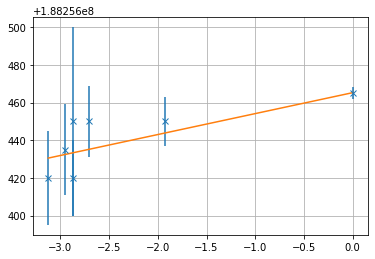

---------- Dec ----------
Beta: [-1.37091876e+01  1.12412040e+08]
Beta Std Error: [1.02158984 0.77194695]
Beta Covariance: [[15.71279944  3.19013321]
 [ 3.19013321  8.97171247]]
Residual Variance: 0.06642010606999005
Inverse Condition #: 0.07603827750430446
Reason(s) for Halting:
  Parameter convergence


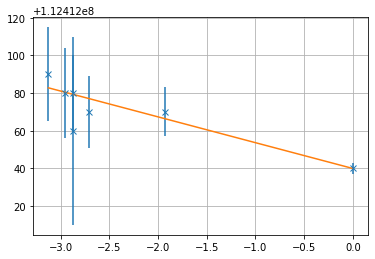

In [5]:
# Define a function (y = a*x + b in our case) to fit the data with.
def linear_func(p, x):
    a, b = p
    return a*x + b

# Create a model for fitting.
linear_model = Model(linear_func)

# x     = x_ra_arr
# y     = y_ra_arr
# y_err = y_err_ra_arr

def do_fitting_odr(x, y, y_err):
    # Create a RealData object using our initiated data from above.
    data = RealData(x, y, \
                    sy=y_err)

    # Set up ODR with the model and data.
    odr = ODR(data, linear_model, beta0=[0., 1.])

    # Run the regression.
    out = odr.run()

    # Use the in-built pprint method to give us results.
    out.pprint()

    # plot the fitting result
    x_fit = np.linspace(x[0], x[-1], 1000)
    y_fit = linear_func(out.beta, x_fit)

    plt.errorbar(x, y, yerr=y_err, linestyle='None', marker='x')
    plt.plot(x_fit, y_fit)
    plt.grid()

    plt.show()
    
# RA
print ('---------- RA ----------')
do_fitting_odr(x=x_ra_arr , y=y_ra_arr , y_err=y_err_ra_arr)
# Dec
print ('---------- Dec ----------')
do_fitting_odr(x=x_dec_arr, y=y_dec_arr, y_err=y_err_dec_arr)

In [6]:
# curve_fit
def func(x, m, n):
    return m * x + n

# RA
print ('---------- RA ----------')
popt, pcov = curve_fit(func, x_ra_arr, y_ra_arr)
perr = np.sqrt(np.diag(pcov))
print (popt)
print (pcov)
print (perr)

# Dec
print ('---------- Dec ----------')
popt, pcov = curve_fit(func, x_dec_arr, y_dec_arr)
perr = np.sqrt(np.diag(pcov))
print (popt)
print (pcov)
print (perr)

---------- RA ----------
[1.13080792e+01 1.88256468e+08]
[[ 21.10739865  50.13092049]
 [ 50.13092049 141.67359388]]
[ 4.5942789  11.90267171]
---------- Dec ----------
[-1.25940835e+01  1.12412040e+08]
[[12.41178632 28.91784163]
 [28.91784163 80.07568083]]
[3.52303652 8.9485016 ]


In [7]:
# Observational time [year]
t0_yr      = time_yr_arr[1]
tf_yr      = time_yr_arr[-1]
t_std_yr   = time_yr_std

# Time different [yr] from the first fitting plot (JVLA K) btw the reference (ALMA B4)
t0_diff_yr = t0_yr - t_std_yr
tf_diff_yr = tf_yr - t_std_yr

# uncertainty for ra
err_arcs_arr    = radec_err_arcs_arr
ra_err_sec_arr  = ra_arcs2sec(radec_err_arcs_arr)

#----------------------------------------------------
# ra_B4_fit & dec_B4_fit
# y = ax + b

# a: proper_ra, proper_dec
proper_ra_fit_masyr   = z_ra_arr[0]        # proper motion (ra)  [mas yr-1]
proper_dec_fit_masyr  = z_dec_arr[0]       # proper motion (dec) [mas yr-1]
proper_ra_fit_secyr   = ra_arcs2sec(proper_ra_fit_masyr* 1e-3)
proper_dec_fit_arcsyr = proper_dec_fit_masyr * 1e-3

# b: ra_0, dec_0
ra_0_fit_mas   = z_ra_arr[1]
dec_0_fit_mas  = z_dec_arr[1]
ra_0_fit_deg   = mas2deg(ra_0_fit_mas)
dec_0_fit_deg  = mas2deg(dec_0_fit_mas)
ra_0_fit_sec, dec_0_fit_arcs = radec_degdeg2secacrs(ra_0_fit_deg, dec_0_fit_deg)

### Plot the fitting results

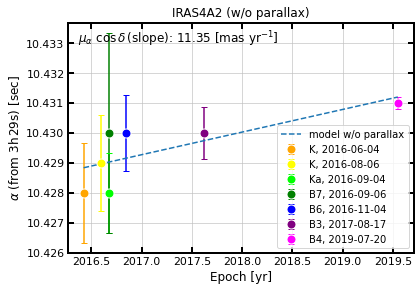

In [8]:
# Plot the fitting result (Proper_RA*cos(dec) v.s. Time)
# a = proper_ra * cos(dec)
fig = plt.figure()
ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

#----------------------------------------------------
# Plot the observations
for i, elm in enumerate(x_ra_arr):
    
    i_shift = i+1
    
    # x: t [yr]
    time_yr          = time_yr_arr[i_shift]
    
    # y: RA(t)  [sec]
    ra_sec           = ra_s_arr[i_shift]      
    # uncertainty for ra [sec]
    ra_err_sec       = ra_err_sec_arr[i_shift]
    
    # plot
    ax.errorbar(x    = time_yr, \
                y    = ra_sec, \
                yerr = ra_err_sec, \
                fmt='o', color = color_list[i_shift], \
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=Band_arr[i_shift]+', '+time_yms_arr[i_shift])

#----------------------------------------------------
# plot the fitting result

# Time
t       = np.linspace(t0_diff_yr, tf_diff_yr, 20)
t_shift = t + time_yr_std

# y = a                  * x + b
# y = proper_ra*cos(dec) * x + ra_0
y_ra_fit_sec = proper_ra_fit_secyr*t + ra_0_fit_sec
slope_ra_txt = float('%.2f' % z_ra_arr[0])

# plot the fitting result
ax.plot(t_shift, y_ra_fit_sec, '--', color='tab:blue', label='model w/o parallax')

#----------------------------------------------------
# Set the figure
# ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
ax.set_title('IRAS4A2 (w/o parallax)', fontsize=12)
ax.set_xlabel('Epoch [yr]', fontsize=12)
ax.set_ylabel(r'$\alpha$ (from %sh$\,$%ss) [sec]'%(ra_hour_int, ra_minute_int), fontsize=12)
ax.text(0.03, 0.93, r'$\mu_{\alpha}$ $\cos\,\delta\,$(slope): %s [mas yr$^{-1}$]'%(slope_ra_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

# set the major and minor tickers
#ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.yaxis.set_major_locator(MultipleLocator(0.002))
#ax.xaxis.set_minor_locator(MultipleLocator(0.2))
#ax.yaxis.set_minor_locator(MultipleLocator(0.001))
ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.grid(color='silver', alpha=0.8)
ax.legend()

plt.savefig('%s4A2_TimeRA_wo_prllx.pdf'%(path_figure))
plt.show()

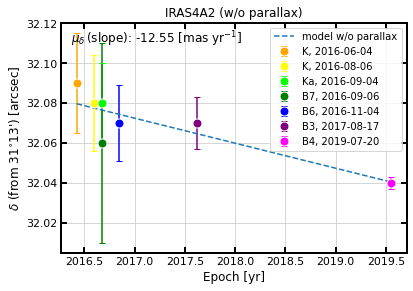

In [9]:
# Plot the fitting result (Proper_Dec v.s. Time)
# a = proper_dec
fig = plt.figure()
ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

#----------------------------------------------------
# Plot the observations
for i, elm in enumerate(x_dec_arr):
    
    i_shift = i+1
    # x: t [yr]
    time_yr       = time_yr_arr[i_shift]
    
    # y: Dec(t) [arcs]
    dec_arcs      = dec_s_arr[i_shift]      
    # uncertainty for dec
    err_arcs      = err_arcs_arr[i_shift]
    
    # plot
    ax.errorbar(x    = time_yr, \
                y    = dec_arcs, \
                yerr = err_arcs, \
                fmt='o', color = color_list[i_shift], \
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=Band_arr[i_shift]+', '+time_yms_arr[i_shift])

#----------------------------------------------------
# plot the fitting result

# Time
t       = np.linspace(t0_diff_yr, tf_diff_yr, 20)
t_shift = t + time_yr_std

# y = a          * x + b
# y = proper_dec * x + dec_0
y_dec_fit_sec = proper_dec_fit_arcsyr*t + dec_0_fit_arcs
slope_dec_txt  = float('%.2f' % z_dec_arr[0])

# plot the fitting result
ax.plot(t_shift, y_dec_fit_sec, '--', color='tab:blue', label='model w/o parallax')

#----------------------------------------------------
# Set the figure
# ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
ax.set_title('IRAS4A2 (w/o parallax)', fontsize=12)
ax.set_xlabel('Epoch [yr]', fontsize=12)
ax.set_ylabel(r"$\delta$ (from %s$^{\circ}$%s') [arcsec]"%(dec_deg_int, dec_arcm_int), fontsize=12)
ax.text(0.03, 0.93, r'$\mu_{\delta}\,$(slope): %s [mas yr$^{-1}$]'%(slope_dec_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

# set the major and minor tickers
# ax.xaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_locator(MultipleLocator(30))
# ax.xaxis.set_minor_locator(MultipleLocator(0.02))
# ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.grid(color='silver', alpha=0.8)
ax.legend()

plt.savefig('%s4A2_TimeDec_wo_prllx.pdf'%(path_figure))
plt.show()

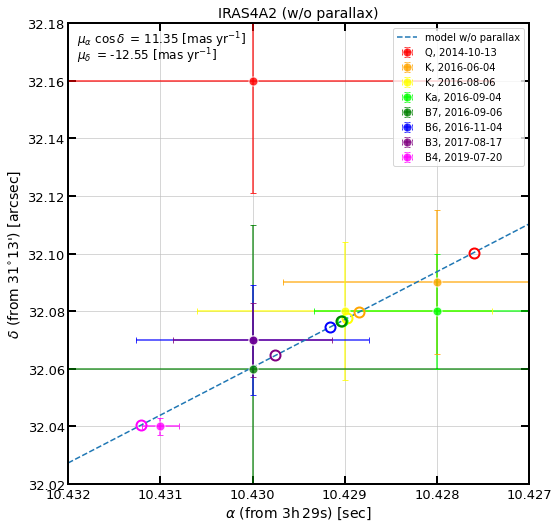

In [10]:
# Plot the fitting result (RA v.s. Dec)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.14,0.12,0.8,0.8]) 

#---------------------------------------
# Plot the observations
for i, band in enumerate(Band_arr):
    
    # x: ra
    ra_sec        = ra_s_arr[i]   
    # y: dec
    dec_arcs      = dec_s_arr[i]  
    # uncertainty for the coordinate
    err_arcs      = radec_err_arcs_arr[i]
    ra_err_sec    = ra_err_sec_arr[i]
    
    ax.errorbar(x    = ra_sec,\
                y    = dec_arcs,\
                xerr = ra_err_sec,\
                yerr = err_arcs ,\
                fmt='o', color = color_list[i],\
                alpha=0.8, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=band+', '+time_yms_arr[i])
    
    #---------------------------------------
    # Plot the fitting result with corresponding observational time 
    
    # Time
    t_diff_yr         = time_yr_arr[i] - time_yr_std
    
    # x: ra(t)
    # y: dec(t)
    ra_fit_sec        = proper_ra_fit_secyr   * t_diff_yr + ra_0_fit_sec
    dec_fit_arcs      = proper_dec_fit_arcsyr * t_diff_yr + dec_0_fit_arcs  
    
    ax.plot(ra_fit_sec, dec_fit_arcs, color = color_list[i], \
            marker='o', fillstyle = 'none', markeredgewidth=2, markersize=10, zorder=10)

#---------------------------------------
# plot the fitting result

# Time
t = np.linspace(-15, 5, 20)

# x: ra(t)  [sec]
# y: dec(t) [arcs]
y_ra_fit_sec   = proper_ra_fit_secyr*t   + ra_0_fit_sec
y_dec_fit_arcs = proper_dec_fit_arcsyr*t + dec_0_fit_arcs

# plot the fitting result
ax.plot(y_ra_fit_sec, y_dec_fit_arcs, '--', color='tab:blue', label='model w/o parallax')

#---------------------------------------
# Set the figure
ax.set_title('IRAS4A2 (w/o parallax)', fontsize=14)
ax.set_xlabel(r'$\alpha$ (from %sh$\,$%ss) [sec]'%(ra_hour_int, ra_minute_int), fontsize=14)
ax.set_ylabel(r"$\delta$ (from %s$^{\circ}$%s') [arcsec]"%(dec_deg_int, dec_arcm_int), fontsize=14)

ax.set_xlim(10.432, 10.427)
ax.set_ylim(32.02, 32.18)

ax.text(0.02, 0.965, r'$\mu_{\alpha}$ $\cos\,\delta\,$ = %s [mas yr$^{-1}$]'%(slope_ra_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.02, 0.93, r'$\mu_{\delta}\,$ = %s [mas yr$^{-1}$]'%(slope_dec_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.grid(color='silver', alpha=0.8)
ax.legend(loc='upper right')

plt.savefig('%s4A2_radec_wo_prllx.pdf'%(path_figure))
plt.show()

#### plot figure: unit [mas]

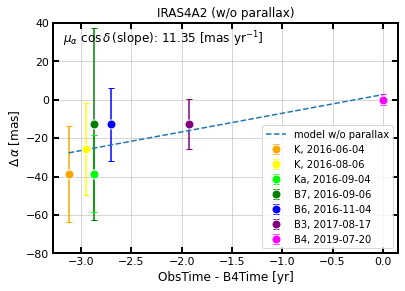

In [11]:
# Plot the fitting result (Proper_RA*cos(dec) v.s. Time)
# a = proper_ra * cos(dec)
fig = plt.figure()
ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

#----------------------------------------------------
# Plot the observations
for i, elm in enumerate(x_ra_arr):
    
    i_shift = i+1

    # x: t - t0 [yr]
    time_diff_yr     = time_diff_yr_arr[i_shift]
       
    # y: RA(t) [mas]
    ra_diff_mass   = (ra_mas_arr[i_shift] - ra_mas_std)* np.cos(np.deg2rad(dec_deg_std))
    # uncertainty for ra [mas]
    radec_err_mas = radec_err_mas_arr[i_shift]
    
    ax.errorbar(x    = time_diff_yr, \
                y    = ra_diff_mass, \
                yerr = radec_err_mas, \
                fmt='o', color = color_list[i_shift], \
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=Band_arr[i_shift]+', '+time_yms_arr[i_shift])

#----------------------------------------------------
# plot the fitting result

# Time
t = np.linspace(t0_diff_yr, tf_diff_yr, 20)

# y = a                  * x + b
# y = proper_ra*cos(dec) * x + ra_0
y_ra_fit      = z_ra_arr[0]*t + z_ra_arr[1]
y_ra_fit_diff = (y_ra_fit - ra_mas_std)* np.cos(np.deg2rad(dec_deg_std))
slope_ra_txt  = float('%.2f' % z_ra_arr[0])

# plot the fitting result
ax.plot(t, y_ra_fit_diff, '--', color='tab:blue', label='model w/o parallax')

#----------------------------------------------------
# Set the figure
# ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
ax.set_title('IRAS4A2 (w/o parallax)', fontsize=12)
ax.set_xlabel('ObsTime - B4Time [yr]', fontsize=12)
ax.set_ylabel(r'$\Delta\, \alpha$ [mas]', fontsize=12)
#ax.set_xlim(40, -80)
ax.set_ylim(-80, 40)
ax.text(0.03, 0.93, r'$\mu_{\alpha}$ $\cos\,\delta\,$(slope): %s [mas yr$^{-1}$]'%(slope_ra_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

# set the major and minor tickers
# ax.xaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_locator(MultipleLocator(30))
# ax.xaxis.set_minor_locator(MultipleLocator(0.02))
# ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.grid(color='silver', alpha=0.8)
ax.legend()

plt.savefig('%s4A2_TimeRA_wo_prllx_mas.pdf'%(path_figure))
plt.show()

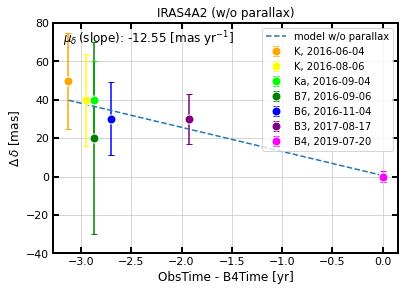

In [12]:
# Plot the fitting result (Proper_Dec v.s. Time)
# a = proper_dec
fig = plt.figure()
ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

#----------------------------------------------------
# Plot the observations
for i, elm in enumerate(x_dec_arr):
    
    i_shift = i+1
    
    # x: t - t0 [yr]
    time_diff_yr     = time_diff_yr_arr[i_shift]
    
    # y: Dec(t) [mas]
    dec_diff_mas     = dec_mas_arr[i_shift] - dec_mas_std
    # uncertainty of ra [mas]
    radec_err_mas = radec_err_mas_arr[i_shift]
    
    ax.errorbar(x    = time_diff_yr, \
                y    = dec_diff_mas, \
                yerr = radec_err_mas, \
                fmt='o', color = color_list[i_shift], \
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=Band_arr[i_shift]+', '+time_yms_arr[i_shift])

#----------------------------------------------------
# plot the fitting result

# Time
t = np.linspace(t0_diff_yr, tf_diff_yr, 20)

# y = a          * x + b
# y = proper_dec * x + dec_0
y_dec_fit      = z_dec_arr[0]*t + z_dec_arr[1]
y_dec_fit_diff = y_dec_fit - dec_mas_std
slope_dec_txt  = float('%.2f' % z_dec_arr[0])

# plot the fitting result
ax.plot(t, y_dec_fit_diff, '--', color='tab:blue', label='model w/o parallax')

#----------------------------------------------------
# Set the figure
# ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
ax.set_title('IRAS4A2 (w/o parallax)', fontsize=12)
ax.set_xlabel('ObsTime - B4Time [yr]', fontsize=12)
ax.set_ylabel(r'$\Delta\, \delta$ [mas]', fontsize=12)
#ax.set_xlim(40, -80)
ax.set_ylim(-40, 80)
ax.text(0.03, 0.93, r'$\mu_{\delta}\,$(slope): %s [mas yr$^{-1}$]'%(slope_dec_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

# set the major and minor tickers
# ax.xaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_locator(MultipleLocator(30))
# ax.xaxis.set_minor_locator(MultipleLocator(0.02))
# ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.grid(color='silver', alpha=0.8)
ax.legend()

plt.savefig('%s4A2_TimeDec_wo_prllx_mas.pdf'%(path_figure))
plt.show()

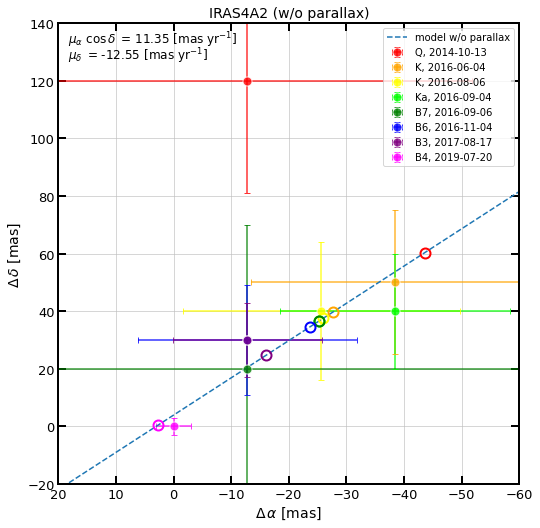

In [13]:
# Plot the fitting result (RA v.s. Dec)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.14,0.12,0.8,0.8]) 

#---------------------------------------
# Plot the observations
for i, band in enumerate(Band_arr):
    
    # ra & dec difference [mas] between each and the standard (B4) obs.
    ra_diff_mas  = (ra_mas_arr[i] - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))
    dec_diff_mas = dec_mas_arr[i] - dec_mas_std

    # uncertainty of the coordinate
    radec_err_mas = radec_err_mas_arr[i]   
    
    ax.errorbar(x    = ra_diff_mas,\
                y    = dec_diff_mas,\
                xerr = radec_err_mas,\
                yerr = radec_err_mas,\
                fmt='o', color = color_list[i],\
                alpha=0.8, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=band+', '+time_yms_arr[i])
    
    #---------------------------------------
    # Plot the fitting result with corresponding observational time 
    
    # Time [yr]
    t_diff_yr       = time_diff_yr_arr[i]
    
    # x: ra(t)  - ra_std [mas]
    ra_fit_mas       = proper_ra_fit_masyr  *t_diff_yr + ra_0_fit_mas
    ra_diff_fit_mas  = (ra_fit_mas  - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))
    
    # y: dec(t) - dec_std [mas]
    dec_fit_mas      = proper_dec_fit_masyr *t_diff_yr + dec_0_fit_mas   
    dec_diff_fit_mas = dec_fit_mas - dec_mas_std
    
    ax.plot(ra_diff_fit_mas, dec_diff_fit_mas, color = color_list[i],\
            marker='o', fillstyle = 'none', markeredgewidth=2, markersize=10, zorder=10)

#---------------------------------------
# plot the fitting result

# Time
t_diff_yr_arr = np.linspace(-15, 5, 20)

# x: ra(t)  - ra_std  [mas]
ra_fit_mas_arr       = proper_ra_fit_masyr  *t_diff_yr_arr + ra_0_fit_mas
ra_diff_fit_mas_arr  = (ra_fit_mas_arr  - ra_mas_std)* np.cos(np.deg2rad(dec_deg_std))
# y: dec(t) - dec_std [mas]
dec_fit_mas_arr      = proper_dec_fit_masyr *t_diff_yr_arr + dec_0_fit_mas   
dec_diff_fit_mas_arr = dec_fit_mas_arr - dec_mas_std

# plot the fitting result
ax.plot(ra_diff_fit_mas_arr, dec_diff_fit_mas_arr, '--', color='tab:blue', label='model w/o parallax')

#---------------------------------------
# Set the figure
ax.set_title('IRAS4A2 (w/o parallax)', fontsize=14)
ax.set_xlabel(r'$\Delta\,\alpha$ [mas]', fontsize=14)
ax.set_ylabel(r'$\Delta\,\delta$ [mas]', fontsize=14)
ax.set_xlim(20, -60)
ax.set_ylim(-20, 140)

ax.text(0.02, 0.965, r'$\mu_{\alpha}$ $\cos\,\delta\,$ = %s [mas yr$^{-1}$]'%(slope_ra_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.02, 0.93, r'$\mu_{\delta}\,$ = %s [mas yr$^{-1}$]'%(slope_dec_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.grid(color='silver', alpha=0.8)
ax.legend(loc='upper right')


plt.savefig('%s4A2_radec_wo_prllx_mas.pdf'%(path_figure))
plt.show()